In [105]:
import datetime
import tensorflow as tf
import tensorflow_datasets as tfds 
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, AveragePooling2D, Reshape, GlobalAveragePooling2D, Conv2DTranspose, MaxPooling2D

In [106]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
def preprocess(data):
    batch_size = 32

    data = data.map(lambda image, target: image)
    data = data.map(lambda image: tf.cast(image, tf.float32))

    noisy_data = data.map(lambda image: image + tf.random.normal(shape=(28,28,1), mean=0., stddev=40.))
    zip_data = tf.data.Dataset.zip((noisy_data, data))

    data = zip_data.map(lambda image, target: ((tf.clip_by_value((image/128. -1), -1, 1), (target/128. -1))))
    # data = data.map(lambda image, target: (tf.expand_dims(image, axis=-1), tf.expand_dims(target, axis=-1)))
    
    data.cache()
    data = data.shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return data

In [108]:
def show_pic_or_didnt_happen(ds):
    # visualize data by plotting images
    for img, target in ds:
        print(img.shape, target.shape)
        plt.imshow(img[0])       
        plt.show()

        plt.imshow(target[0])       
        plt.show()
        break    

In [109]:
def visualize(img, target):
    plt.imshow(img[0])       
    plt.show()

    plt.imshow(target[0])       
    plt.show()


(32, 28, 28, 1) (32, 28, 28, 1)


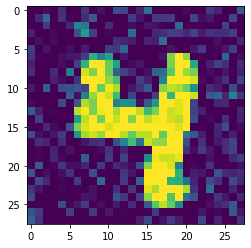

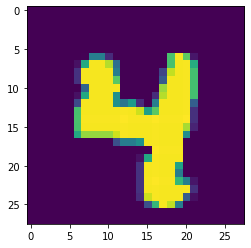

2023-01-02 15:11:23.458608: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-01-02 15:11:23.461520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [110]:
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

show_pic_or_didnt_happen(train_ds)

# Encoder


In [111]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super().__init__()
    # input conv1 = 28x28x1
    self.conv1 = Conv2D(12, 3, activation='relu', padding='same')
    # output conv1 = 28x28x12
    self.conv2 = Conv2D(12, 3, activation='relu', padding='same')
    # output conv2 = 28x28x12
    self.pooling1 = MaxPooling2D()
    # output pooling1 = 14x14x12
    self.conv3 = Conv2D(24, 3, activation='relu', padding='same')
    # output conv3 = 14x14x24
    self.conv4 = Conv2D(24, 3, activation='relu', padding='same')    
    # output conv3 = 14x14x24

    self.pooling2 = MaxPooling2D()
    # output pooling1 = 7x7x24
    self.conv5 = Conv2D(48, 3, activation='relu', padding='same')
    # output conv3 = 7x7x48
    self.conv6 = Conv2D(48, 3, activation='relu', padding='same')
    # output conv3 = 7x7x48
    self.globalpooling = GlobalAveragePooling2D()
    # output global pool 48
    self.out = Dense(24, activation="sigmoid")


  @tf.function
  def __call__(self, x, training=False):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pooling1(x)
    x = self.conv3(x)
    x = self.conv4(x)    
    x = self.pooling2(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

In [112]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(196, activation="elu")
        self.reshape = Reshape((7, 7, 4))
        self.convT1 = Conv2DTranspose(4, (3, 3), strides=2, activation="elu", padding="same")
        self.convT2 = Conv2DTranspose(2, (3, 3), strides=2, activation="elu", padding="same")
        self.conv = Conv2D(1, (3, 3), strides=1, activation="sigmoid", padding="same")

    @tf.function
    def __call__(self, x, training=False):
        x = self.dense(x)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.conv(x)
        return x

In [113]:
class Autoencoder(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

    self.metrics_list = [
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.Mean(name="loss")]

    self.optimizer = optimizer
    self.loss_function = loss_function

  @property
  def metrics(self):
    return self.metrics_list
    
  def reset_metrics(self):
     for metric in self.metrics:
        metric.reset_state()

  def call(self, input, training=False):
    embedding = self.enc(input)
    output = self.dec(embedding)
    return output

  @tf.function
  def train_step(self, data):
    image, target = data
    with tf.GradientTape() as tape: 
      prediction = self(image, training = True)
      loss = self.loss_function(target, prediction)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
    self.metrics[0].update_state(target, prediction)
    self.metrics[1].update_state(loss)  

  @tf.function
  def test_step(self, data):
    image, target = data
    prediction = self(image, training = False)
    loss = self.loss_function(target, prediction)
    self.metrics[0].update_state(target, prediction)
    self.metrics[1].update_state(loss)
    return prediction, target

    

In [114]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            prediction, target = model.test_step(data)

        visualize(prediction, target)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")

100%|██████████| 1875/1875 [00:18<00:00, 100.38it/s]


Epoch:  1
Loss:  -10.819921 Accuracy:  0.0015867347 (Train)


100%|██████████| 313/313 [00:03<00:00, 102.66it/s]


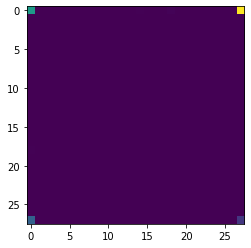

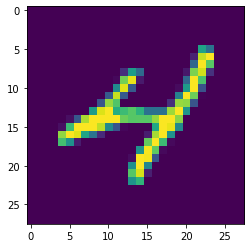

Loss:  -11.353711 Accuracy:  0.0016920918 (Test)


100%|██████████| 1875/1875 [00:18<00:00, 103.38it/s]


Epoch:  2
Loss:  -11.409817 Accuracy:  0.0015932398 (Train)


100%|██████████| 313/313 [00:03<00:00, 103.69it/s]


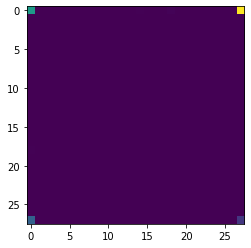

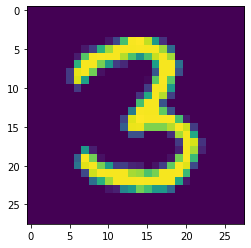

Loss:  -11.352554 Accuracy:  0.0016920918 (Test)


100%|██████████| 1875/1875 [00:16<00:00, 110.73it/s]


Epoch:  3
Loss:  -11.409826 Accuracy:  0.0015932398 (Train)


100%|██████████| 313/313 [00:02<00:00, 107.28it/s]


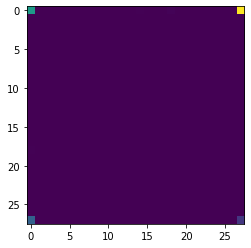

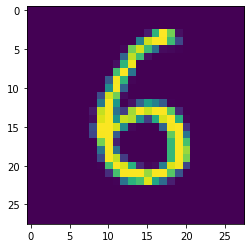

Loss:  -11.35312 Accuracy:  0.0016920918 (Test)


100%|█████████▉| 1873/1875 [00:17<00:00, 132.56it/s]

In [116]:
batch_size = 32
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.BinaryCrossentropy()

autoencoder = Autoencoder(optimizer=optimizer, loss_function=loss_function)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(autoencoder, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

In [ ]:
%tensorboard --logdir logs